In [1]:
# Importing necessary packages
import numpy as np
from scipy.io import wavfile
import math
import matplotlib.pyplot as plt

In [2]:
# Function to plot spectogram
def plot_spectogram(frequency, data):
    plt.title('Spectrogram')
    plt.specgram(data,Fs=frequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Functions to compute average of non-diagonal elements

In [3]:
def compute_non_diag_avg(temp_arr, reduced_log_data):
    #Finding mean of clean data
    temp_mean = np.mean(reduced_log_data, axis = 1)
    temp_mean = np.reshape(temp_mean, (128,1))

    x_double_prime = np.matmul(temp_arr,(reduced_log_data-temp_mean))
    x_double_prime_mean = np.mean(x_double_prime, axis = 1)
    x_double_prime_mean = np.reshape(x_double_prime_mean,(128,1))

    Sx_after_whitening = np.matmul((x_double_prime-x_double_prime_mean),np.transpose(x_double_prime-x_double_prime_mean))
    Sx_after_whitening = np.multiply(Sx_after_whitening, 1/298)

    Sx_after_whitening_abs = np.absolute(Sx_after_whitening)

    sum_non_diag = 0
    for i in range(128):
        for j in range(128):
            if(i==j):
                continue
            sum_non_diag += Sx_after_whitening_abs[i][j]

    avg_non_diag = sum_non_diag/(128*128-128)
    
    return avg_non_diag
    

In [4]:
def compute_non_diag_avg_B(temp_arr_B, reduced_log_data_B):
    #Finding mean of clean data
    temp_mean = np.mean(reduced_log_data_B, axis = 1)
    temp_mean = np.reshape(temp_mean, (128,1))

    x_double_prime_B = np.matmul(temp_arr_B,(reduced_log_data_B-temp_mean))
    x_double_prime_mean_B = np.mean(x_double_prime_B, axis = 1)
    x_double_prime_mean_B = np.reshape(x_double_prime_mean_B,(128,1))

    Sx_after_whitening_B = np.matmul((x_double_prime_B-x_double_prime_mean_B),np.transpose(x_double_prime_B-x_double_prime_mean_B))
    Sx_after_whitening_B = np.multiply(Sx_after_whitening_B, 1/298)

    Sx_after_whitening_abs_B = np.absolute(Sx_after_whitening_B)

    sum_non_diag_B = 0
    for i in range(128):
        for j in range(128):
            if(i==j):
                continue
            sum_non_diag_B += Sx_after_whitening_abs_B[i][j]

    avg_non_diag_B = sum_non_diag_B/(128*128-128)

    return avg_non_diag_B

# Reading Files and processing

In [5]:
# Reading files
samplerate_clean, data_clean = wavfile.read(r"C:\Users\ujjaw\Desktop\MLSP_Assignments\Ass1\5. Speech Spectogram\speechFiles\clean.wav")
samplerate_noise, data_noise = wavfile.read(r"C:\Users\ujjaw\Desktop\MLSP_Assignments\Ass1\5. Speech Spectogram\speechFiles\noise.wav")
samplerate_noisy, data_noisy = wavfile.read(r"C:\Users\ujjaw\Desktop\MLSP_Assignments\Ass1\5. Speech Spectogram\speechFiles\noisy.wav")

In [6]:
#Finding Feature Vector of Clean, Noise and Noisy wav file for 298 frames
hamming_window_size = int(25*16000/1000)
shift_length = int(10*16000/1000)
feature_vector_clean = []
feature_vector_noise = []
feature_vector_noisy = []
for i in range(298):
    start_point = i*shift_length
    end_point = i*shift_length + hamming_window_size
    feature_vector_clean.append(data_clean[start_point:end_point])
    feature_vector_noise.append(data_noise[start_point:end_point])
    feature_vector_noisy.append(data_noisy[start_point:end_point])
    
feature_vector_clean = np.transpose(np.array(feature_vector_clean))
feature_vector_noise = np.transpose(np.array(feature_vector_noise))
feature_vector_noisy = np.transpose(np.array(feature_vector_noisy))

In [7]:
# Computing Fast Fourier Transformation for the feature vectors
fft_clean = np.fft.fft(feature_vector_clean, n = 256, axis = 0)
fft_noise = np.fft.fft(feature_vector_noise, n = 256, axis = 0)
fft_noisy = np.fft.fft(feature_vector_noisy, n = 256, axis = 0)

In [8]:
#Taking the first 128 dimension as the other half is symmetric
reduced_clean = fft_clean[:128]
reduced_noise = fft_noise[:128]
reduced_noisy = fft_noisy[:128]

In [9]:
# Extracting the magnitude of the first half of the frequency
reduced_abs_clean = np.absolute(reduced_clean)
reduced_abs_noise = np.absolute(reduced_noise)
reduced_abs_noisy = np.absolute(reduced_noisy)

# Taking log of magnitude of the first half of the frequency
reduced_log_clean = np.log(reduced_abs_clean)
reduced_log_noise = np.log(reduced_abs_noise)
reduced_log_noisy = np.log(reduced_abs_noisy)

Clean File SPECTOGRAM


C:\Users\ujjaw\AppData\Local\Temp\ipykernel_11724\593759964.py:4: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  plt.specgram(data,Fs=frequency)


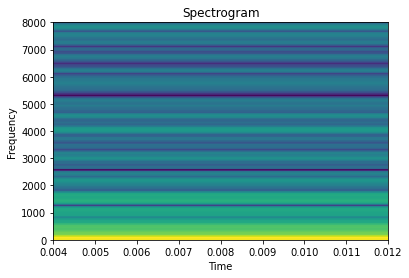

In [10]:
print('Clean File SPECTOGRAM')
plot_spectogram(samplerate_clean,reduced_log_clean)

Noisy File SPECTOGRAM


C:\Users\ujjaw\AppData\Local\Temp\ipykernel_11724\593759964.py:4: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  plt.specgram(data,Fs=frequency)


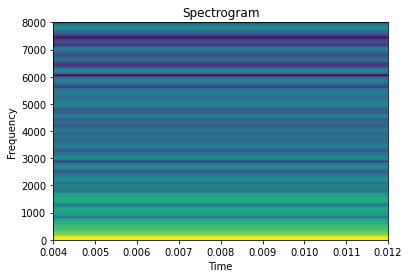

In [11]:
print('Noisy File SPECTOGRAM')
plot_spectogram(samplerate_noisy,reduced_log_noisy)

# Computing Whitening Transformation from clean file

In [12]:
#Finding mean of clean data
clean_mean = np.mean(reduced_log_clean, axis = 1)
clean_mean = np.reshape(clean_mean, (128,1))

# Finding Cov matrix of clean data Sx
Sx_clean = np.matmul((reduced_log_clean-clean_mean),np.transpose(reduced_log_clean-clean_mean))
Sx_clean = np.multiply(Sx_clean,1/298)

# Performing eigen analysis on Sx_clean
e_val, e_vec = np.linalg.eig(Sx_clean)

#Sorting Eigen Values and Corresponding Eigen Vectors
idx = e_val.argsort()[::-1]   
e_val = e_val[idx]
e_vec = e_vec[:,idx]

# Finding sigma^(1/2)
sigma_power_half = np.array(np.zeros((128, 128)))
for i in range(128):
    sigma_power_half[i][i] = math.sqrt(e_val[i])
    
sigma_power_half_inverse = np.linalg.inv(sigma_power_half)

temp_np_array = np.matmul(sigma_power_half_inverse, np.transpose(e_vec))

# Applying whitening transformation on clean file

In [13]:
avg_non_diag_clean = compute_non_diag_avg(temp_np_array, reduced_log_clean)
print ("Average of non-diagnoal elements Clean_A = ",avg_non_diag_clean)

Average of non-diagnoal elements Clean_A =  5.624106188325451e-15


# Applying whitening transformation on noisy file

In [14]:
avg_non_diag_noisy = compute_non_diag_avg(temp_np_array, reduced_log_noisy)
print ("Average of non-diagnoal elements Noisy_A =",avg_non_diag_noisy)

Average of non-diagnoal elements Noisy_A = 0.20262565358264523


# Part B


# Computing Whitening Transformation from noisy file

In [15]:
#Finding mean of noisy data
noisy_mean = np.mean(reduced_log_noisy, axis = 1)
noisy_mean = np.reshape(noisy_mean, (128,1))

# Finding Cov matrix of clean data Sx
Sx_noisy = np.matmul((reduced_log_noisy-noisy_mean),np.transpose(reduced_log_noisy-noisy_mean))
Sx_noisy = np.multiply(Sx_noisy,1/298)

# Performing eigen analysis on Sx_noisy
e_val_B, e_vec_B = np.linalg.eig(Sx_noisy)

#Sorting Eigen Values and Corresponding Eigen Vectors
idx = e_val_B.argsort()[::-1]   
e_val_B = e_val_B[idx]
e_vec_B = e_vec_B[:,idx]

# Finding sigma^(1/2)
sigma_power_half_B = np.array(np.zeros((128, 128)))
for i in range(128):
    sigma_power_half_B[i][i] = math.sqrt(e_val_B[i])

sigma_power_half_inverse_B = np.linalg.inv(sigma_power_half_B)

temp_np_array_B = np.matmul(sigma_power_half_inverse_B, np.transpose(e_vec_B))

# Applying whitening transformation on clean file

In [16]:
avg_non_diag_clean_B = compute_non_diag_avg_B(temp_np_array_B, reduced_log_clean)
print ("Average of non-diagnoal elements Clean_B = ",avg_non_diag_clean_B)

Average of non-diagnoal elements Clean_B =  0.12678101775576353


# Applying whitening transformation on noisy file


In [17]:
avg_non_diag_noisy_B = compute_non_diag_avg_B(temp_np_array_B, reduced_log_noisy)
print ("Average of non-diagnoal elements Noisy_B = ",avg_non_diag_noisy_B)

Average of non-diagnoal elements Noisy_B =  1.1065210379219143e-15


Observation

Whitening using clean data 
    i. average covariance between the frames is higher in noisy file
    ii. average covariance between the frames is lower in clean file

Whereas, a complete opposite is observed when Whitening is done using noisy data
    i. average covariance between the frames is lower in noisy file
    ii. average covariance between the frames is higher in clean file
